In [1]:
import autogen
from opto.trace import bundle, node
from opto.optimizers import FunctionOptimizer
from opto.trace.nodes import GRAPH

from opto.optimizers.opro import OPRO as FunctionOptimizer  ## Test


def blackbox(x):
    return -x * 2


@bundle()
def bar(x):
    "This is a test function, which does negative scaling."
    return blackbox(x)


def foo(x):
    y = x + 1
    return x * y


# foobar is a composition of custom function and built-in functions


def foobar(x):
    return foo(bar(x))


def user(x):
    if x < 50:
        return "The number needs to be larger."
    else:
        return "Success."

# LLM Optimization based Language Feedback

Here we show a small example of how to apply `trace` to optimize python objects based on language feedback. Here we want to change the input to function `foobar` such that output is large enough. `foobar` is a function that is composed of `foo` based on built-in operators and `bar` which is a blackbox function, whose information is only given via the docstring.  



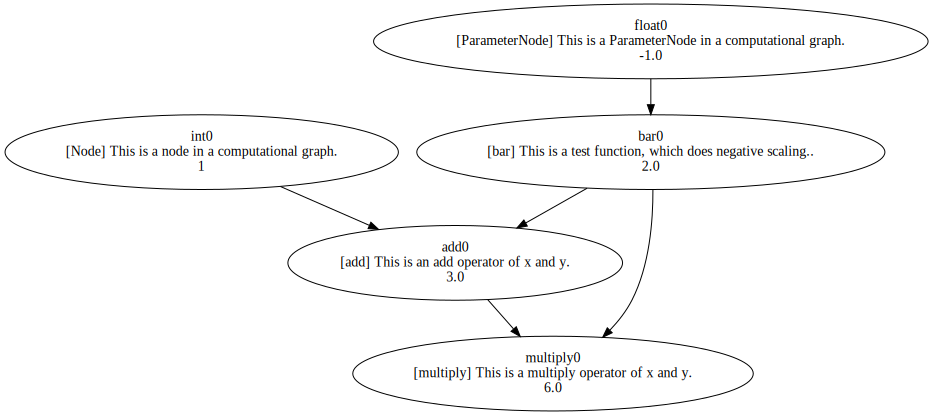

In [2]:
# One-step optimization example
x = node(-1.0, trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))
output = foobar(x)
feedback = user(output.data)
optimizer.zero_feedback()
optimizer.backward(output, feedback, visualize=True)  # this is equivalent to the below line
# output.backward(feedback, propagator=optimizer.propagator, visualize=visualize)

The propagated feedback contains graph structure, data of the nodes in the graph, and the transformation used in the graph. They're presented in a python-like syntax.

In [3]:
from opto.optimizers.function_optimizer import node_to_function_feedback

print("Function Feedback")
for k, v in x.feedback.items():
    v = v[0]
    f_feedback = node_to_function_feedback(v)
    print("Graph:")
    for kk, vv in f_feedback.graph:
        print(f"  {kk}: {vv}")
    print("Roots:")
    for kk, vv in f_feedback.roots.items():
        print(f"  {kk}: {vv}")
    print("Others:")
    for kk, vv in f_feedback.others.items():
        print(f"  {kk}: {vv}")
    print("Documentation:")
    for kk, vv in f_feedback.documentation.items():
        print(f"  {kk}: {vv}")
    print("Output:")
    for kk, vv in f_feedback.output.items():
        print(f"  {kk}: {vv}")
    print("User Feedback:")
    print(f"  {f_feedback.user_feedback}")

Function Feedback
Graph:
  1: bar0 = bar(x=float0)
  2: add0 = add(x=bar0, y=int0)
  3: multiply0 = multiply(x=bar0, y=add0)
Roots:
  int0: (1, None)
  float0: (-1.0, None)
Others:
  bar0: (2.0, None)
  add0: (3.0, None)
Documentation:
  bar: [bar] This is a test function, which does negative scaling..
  add: [add] This is an add operator of x and y.
  multiply: [multiply] This is a multiply operator of x and y.
Output:
  multiply0: (6.0, None)
User Feedback:
  The number needs to be larger.


Once the feedback is propagated, we can call the optimization to change the variable based on the feedback.

In [4]:
old_variable = x.data
optimizer.step(verbose=True)

print("\nAfter step")
print("old variable", old_variable)
print("new variable", x.data)

Prompt
 
Output_format: Your output should be in the following json format, satisfying the json syntax:

{{
"suggestion": {{
    <variable_1>: <suggested_value_1>,
    <variable_2>: <suggested_value_2>,
}}
}}

When suggestion variables, write down the suggested values in "suggestion".  When <type> of a variable is (code), you should write the new definition in the format of python code without syntax errors, and you should not change the function name or the function signature.

If no changes or answer are needed, just output TERMINATE.

Below are some example variables and their feedbacks.

{
    "variables": {
        "float0": -1.0
    },
    "feedback": "The number needs to be larger."
}


Come up with a new variable in accordance to feedback.

LLM response:
 {
"suggestion": {
    "float0": 1.0
}
}

After step
old variable -1.0
new variable 1.0


# Example of Full Optimization Loop

We can apply the steps above repetitively to create a training loop to optimize the variable according to the user. Notice because of the way `foobar` works, the optimizer actually needs to change the input to be lower in order to make the output to be larger (which is what the user suggests). 

This is a non-trivial problem, becasue the optimizer sees only

```
output = blackbox(x) * (blackbox(x)+1)
```

and the hint/docstring `"This is a test function, which does scaling and negation."` about how `blackbox` works. The optimizer needs to figure out how to change the input based on this vague information.



In [5]:
# A small example of how to use the optimizer in a loop
GRAPH.clear()
x = node(-1.0, trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))


history = [x.data]
feedback = ""
while feedback.lower() != "Success.".lower():
    output = foobar(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

variable=-1.0, output=6.0, feedback=The number needs to be larger.
variable=1.0, output=2.0, feedback=The number needs to be larger.
variable=2.0, output=12.0, feedback=The number needs to be larger.
variable=3.0, output=30.0, feedback=The number needs to be larger.
variable=4.0, output=56.0, feedback=Success.
History
  0: -1.0
  1: 1.0
  2: 2.0
  3: 3.0
  4: 4.0
  5: 5.0


# Adding constraint. 

We can add constraint to parameter nodes to guide the search. In this small example, the constraint info helps save one optimization step.

In [6]:
# A small example of how to use the optimizer in a loop
GRAPH.clear()
x = node(-1.0, trainable=True, constraint="The value should be greater than 2.0")
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
while feedback.lower() != "Success.".lower():
    output = foobar(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

variable=-1.0, output=6.0, feedback=The number needs to be larger.
variable=1.0, output=2.0, feedback=The number needs to be larger.
variable=2.0, output=12.0, feedback=The number needs to be larger.
variable=3.0, output=30.0, feedback=The number needs to be larger.
variable=4.0, output=56.0, feedback=Success.
History
  0: -1.0
  1: 1.0
  2: 2.0
  3: 3.0
  4: 4.0
  5: 5.0


# Example of optimizing strings

Below is a similar example, except the variable is written in text and is converted by a poor converter to numbers before inputting to `foo` and `bar`.

In [7]:
@bundle()
def convert_english_to_numbers(x):
    """This is a function that converts English to numbers. This function has limited ability."""
    # remove speical characters, like, ", &, etc.
    x = x.replace('"', "")
    try:  # Convert string to integer
        return int(x)
    except:
        pass
    # Convert intergers written in Engligsh in [-10, 10] to numbers
    if x == "negative ten":
        return -10
    if x == "negative nine":
        return -9
    if x == "negative eight":
        return -8
    if x == "negative seven":
        return -7
    if x == "negative six":
        return -6
    if x == "negative five":
        return -5
    if x == "negative four":
        return -4
    if x == "negative three":
        return -3
    if x == "negative two":
        return -2
    if x == "negative one":
        return -1
    if x == "zero":
        return 0
    if x == "one":
        return 1
    if x == "two":
        return 2
    if x == "three":
        return 3
    if x == "four":
        return 4
    if x == "five":
        return 5
    if x == "six":
        return 6
    if x == "seven":
        return 7
    if x == "eight":
        return 8
    if x == "nine":
        return 9
    if x == "ten":
        return 10
    return "FAIL"


def user(x):
    if x == "FAIL":
        return "The text cannot be converted to a number."
    if x < 50:
        return "The number needs to be larger."
    else:
        return "Success."


def foobar_text(x):
    output = convert_english_to_numbers(x)
    if output.data == "FAIL":  # This is not traced
        return output
    else:
        return foo(bar(output))

In [8]:
GRAPH.clear()
x = node("negative point one", trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = [x.data]
feedback = ""
while feedback.lower() != "Success.".lower():
    output = foobar_text(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)
    print(f"variable={x.data}, output={output.data}, feedback={feedback}")  # logging
    optimizer.step()
    history.append(x.data)  # logging

print("History")
for i, v in enumerate(history):
    print(f"  {i}: {v}")

variable=negative point one, output=FAIL, feedback=The text cannot be converted to a number.
variable=-0.1, output=FAIL, feedback=The text cannot be converted to a number.
variable=-0.1, output=FAIL, feedback=The text cannot be converted to a number.
variable=negative one tenth, output=FAIL, feedback=The text cannot be converted to a number.
variable=0.1, output=FAIL, feedback=The text cannot be converted to a number.
variable=0.1, output=FAIL, feedback=The text cannot be converted to a number.
variable=one, output=2, feedback=The number needs to be larger.
variable=2, output=12, feedback=The number needs to be larger.
variable=3, output=30, feedback=The number needs to be larger.
variable=4, output=56, feedback=Success.
History
  0: negative point one
  1: -0.1
  2: -0.1
  3: negative one tenth
  4: 0.1
  5: 0.1
  6: one
  7: 2
  8: 3
  9: 4
  10: 5


# Example of optimizing functions

We can use `trace` to optimize python function directly. This can be achieved by setting `variable=True` when decorating a custom function by `@bundle`. This would create a `ParameterNode` in the operator, which can be accessed by the `parameter` attribute of the decorated function. It can be used like any other parameters and sent to the optimizer.

In [9]:
GRAPH.clear()


def user(output):
    if output < 0:
        return "Success."
    else:
        return "Try again. The output should be negative"


# We make this function as a parameter that can be optimized.


@bundle(trainable=True)
def my_fun(x):
    """Test function"""
    return x**2 + 1


x = node(-1, trainable=False)
optimizer = FunctionOptimizer([my_fun.parameter], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

feedback = ""
while feedback != "Success.":
    output = my_fun(x)
    feedback = user(output.data)
    optimizer.zero_feedback()
    optimizer.backward(output, feedback)

    print(f"output={output.data}, feedback={feedback}, variables=\n")  # logging
    for p in optimizer.parameters:
        print(p.name, p.data)
    optimizer.step(verbose=False)

output=2, feedback=Try again. The output should be negative, variables=

__code:0 def my_fun(x):
    """Test function"""
    return x**2 + 1
output=-2, feedback=Success., variables=

__code:0 def my_fun(x):
    """Test function"""
    return -(x**2 + 1)


# Example of hyper-parameter optimization for ML models

We can use `trace` to optimize the hyper-parameters of a machine learning model using language feedbacks.

In [10]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import numpy as np


train_samples = 10000
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=train_samples, test_size=20000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

/home/chinganc/miniconda3/envs/autogen/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


The language feedback consists of a text representation of the validation accuracy:

In [11]:
def scorer(classifier, guess, history):
    score = classifier.score(X_validation, y_validation) * 100
    sparsity = np.mean(classifier.coef_ == 0) * 100
    return_feedback = f"\nScore is the accuracy of the classifier on the validation set, and should be maximized."
    return_feedback += f"\nSparsity is the percentage of zero coefficients in the classifier. If the classifier is overfit, a higher sparsity will yield a better score. If the classifier is underfit however, a lower sparsity will yield a better score."
    return_feedback += f"By lowering the regularization parameter (must always be positive), the sparsity will increase. By increasing the regularization parameter, the sparsity will decrease."
    return_feedback += f"\n\nMost recent guess: \nRegularization Parameter: {guess:.4f}, Score: {score:.2f}%, Sparsity: {sparsity:.2f}%"
    if len(history) > 0:
        return_feedback += f"\n\nHistory of guesses:"
        for item in history:
            return_feedback += (
                f"\nRegularization Parameter: {item[0]:.4f}, Score: {item[1]:.2f}%, Sparsity: {item[2]:.2f}%"
            )
    return return_feedback, score, sparsity


@bundle(trainable=False)
def train_classifier(regularization_parameter):
    """regularization_parameter is a positive number that controls the sparsity of the classifier. Lower values will increase sparsity, and higher values will decrease sparsity."""
    classifier = LogisticRegression(C=regularization_parameter, penalty="l1", solver="saga", tol=0.1)
    classifier.fit(X_train, y_train)
    return classifier

In [12]:
x = node(0.005, trainable=True)
optimizer = FunctionOptimizer([x], config_list=autogen.config_list_from_json("OAI_CONFIG_LIST"))

history = []
bestScore = None
bestRegularization = None
for i in range(10):
    classifier = train_classifier(x)
    fb, score, sparsity = scorer(classifier.data, x.data, history)
    history.append((x.data, score, sparsity))
    print(f"variable={x.data}, feedback={fb}")  # logging
    if bestScore is None or score > bestScore:
        bestScore = score
        bestRegularization = x.data

    optimizer.zero_feedback()
    optimizer.backward(classifier, fb)
    optimizer.step()

print("Best regularization parameter:", bestRegularization)
print("Best score:", bestScore)

variable=0.005, feedback=
Score is the accuracy of the classifier on the validation set, and should be maximized.
Sparsity is the percentage of zero coefficients in the classifier. If the classifier is overfit, a higher sparsity will yield a better score. If the classifier is underfit however, a lower sparsity will yield a better score.By lowering the regularization parameter (must always be positive), the sparsity will increase. By increasing the regularization parameter, the sparsity will decrease.

Most recent guess: 
Regularization Parameter: 0.0050, Score: 83.03%, Sparsity: 79.36%
variable=0.003, feedback=
Score is the accuracy of the classifier on the validation set, and should be maximized.
Sparsity is the percentage of zero coefficients in the classifier. If the classifier is overfit, a higher sparsity will yield a better score. If the classifier is underfit however, a lower sparsity will yield a better score.By lowering the regularization parameter (must always be positive), t